In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime
from math import floor
from termcolor import colored as cl 


from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

## Generate Dataset
---

In [2]:
# set ticker
ticker = "NVDA"

# set timeframe for data
start = '2010-01-01'
end = '2021-01-01'

# pull historical stock data from 1/10/2005 to 3/8/2021
yf.pdr_override()
stock_data = pdr.get_data_yahoo(ticker, start=start, end=end)

# drop Dividends and Stock Split columns
stock_data = stock_data.drop(columns=['Adj Close'])
stock_data.head()

[*********************100%***********************]  1 of 1 completed


Open       High        Low      Close    Volume
Date                                                            
2010-01-04  18.510000  18.620001  18.110001  18.490000  20005100
2010-01-05  18.420000  18.959999  18.420000  18.760000  18216200
2010-01-06  18.750000  18.920000  18.570000  18.879999  16229200
2010-01-07  18.780001  18.860001  18.370001  18.510000  13694800
2010-01-08  18.360001  18.680000  18.250000  18.549999  11954200

### Filter the dataset

In [3]:
# Filter the date index and close columns
signals_df = stock_data.loc[:, ["Close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Add in a binary classifier for positive and negative price changes.
# signals_df['Target'] = (
#     (np.where(signals_df['Actual Returns'] > 0.01, 1.0, 0.0)) + 
#     (np.where(signals_df['Actual Returns'] < -0.01, -1.0, 0.0))
# )


signals_df['Target'] = np.where(signals_df['Actual Returns'].shift(-1) > 0, 1, 0)


# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())


# signals_df['Target'].value_counts()


Close  Actual Returns  Target
Date                                         
2010-01-05  18.760000        0.014603       1
2010-01-06  18.879999        0.006397       0
2010-01-07  18.510000       -0.019597       1
2010-01-08  18.549999        0.002161       0
2010-01-11  18.290001       -0.014016       0

Close  Actual Returns  Target
Date                                          
2020-12-24  519.750000       -0.001191       0
2020-12-28  516.000000       -0.007215       1
2020-12-29  517.729980        0.003353       1
2020-12-30  525.830017        0.015645       0
2020-12-31  522.200012       -0.006903       0

## Generate trading signals
---

### RSI

RSI = 100 – [100 / ( 1 + (EMA_up / EMA_down) ) ] where,

EMAup = Exponential Moving Average of Upward Price Change

EMAdown = Exponential Moving Average of Downward Price Change

In [4]:
# Set RSI trading window
RSI_window = 14

#create new df for bollinger bands
RSI_df = signals_df.copy()

#Create function for RSI calculation
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

RSI_df [f'rsi'] = get_rsi(RSI_df['Close'], RSI_window)
RSI_df = RSI_df.dropna()
RSI_df

Close  Actual Returns  Target        rsi
Date                                                     
2010-01-11   18.290001       -0.014016       0  70.476734
2010-01-12   17.670000       -0.033898       1  52.577276
2010-01-13   17.910000        0.013582       0  57.117502
2010-01-14   17.629999       -0.015634       0  50.984639
2010-01-15   17.110001       -0.029495       1  41.971497
...                ...             ...     ...        ...
2020-12-24  519.750000       -0.001191       0  43.562286
2020-12-28  516.000000       -0.007215       1  41.655126
2020-12-29  517.729980        0.003353       1  42.897147
2020-12-30  525.830017        0.015645       0  48.432355
2020-12-31  522.200012       -0.006903       0  46.267841

[2764 rows x 4 columns]

In [5]:
#RSI Trading Signal

upper_limit = 70
lower_limit = 30


# Calculate rolling mean and standard deviation
RSI_df['RSI_mid_band'] = RSI_df['Close'].rolling(window=RSI_window).mean()
RSI_df['RSI_std'] = RSI_df['Close'].rolling(window=14).std()

# Calculate upper and lowers bands of bollinger band
RSI_df['RSI_upper_band']  = RSI_df['RSI_mid_band'] + (RSI_df['RSI_std'] * 1)
RSI_df['RSI_lower_band']  = RSI_df['RSI_mid_band'] - (RSI_df['RSI_std'] * 1)


# Calculate RSI trading signal
RSI_df['RSI_long'] = np.where(RSI_df['rsi'] < lower_limit, 1.0, 0.0)
RSI_df['RSI_short'] = np.where(RSI_df['rsi'] > upper_limit, -1.0, 0.0)
RSI_df['RSI_signal'] = RSI_df['RSI_long'] + RSI_df['RSI_short']

# RSI_df['RSI_signal'] = np.where(RSI_df['rsi'].shift(-1) < lower_limit, 1.0, 0)

    
RSI_df['RSI_signal'].value_counts()

 0.0    2380
-1.0     321
 1.0      63
Name: RSI_signal, dtype: int64

<AxesSubplot:xlabel='Date'>

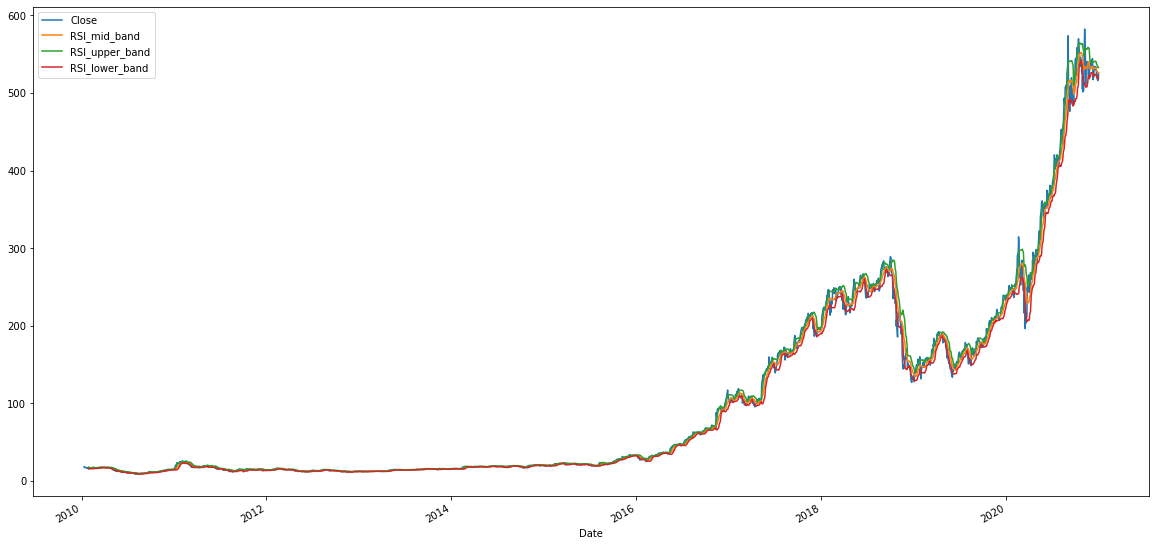

In [6]:
# Plot the RSI for closing prices
RSI_df[['Close','RSI_mid_band','RSI_upper_band','RSI_lower_band']].plot(figsize=(20,10))

In [7]:
# Calculate the strategy returns and add them to the signals_df DataFrame
RSI_df['Strategy Returns'] = RSI_df['Actual Returns'] * RSI_df['RSI_signal'].shift()

# Calculate the points in time at which a position should be taken, 1 or -1
RSI_df['Entry/Exit'] = RSI_df['RSI_signal'].diff()

# # Visualize exit position relative to close price
RSI_df['exit'] = RSI_df[RSI_df['Entry/Exit'] == 0]['Close']
RSI_df['entry'] = RSI_df[RSI_df['Entry/Exit'] == 1.0]['Close']

# Review the DataFrame
display(RSI_df.head())
display(RSI_df.tail())

Close  Actual Returns  Target        rsi  RSI_mid_band  \
Date                                                                     
2010-01-11  18.290001       -0.014016       0  70.476734           NaN   
2010-01-12  17.670000       -0.033898       1  52.577276           NaN   
2010-01-13  17.910000        0.013582       0  57.117502           NaN   
2010-01-14  17.629999       -0.015634       0  50.984639           NaN   
2010-01-15  17.110001       -0.029495       1  41.971497           NaN   

            RSI_std  RSI_upper_band  RSI_lower_band  RSI_long  RSI_short  \
Date                                                                       
2010-01-11      NaN             NaN             NaN       0.0       -1.0   
2010-01-12      NaN             NaN             NaN       0.0        0.0   
2010-01-13      NaN             NaN             NaN       0.0        0.0   
2010-01-14      NaN             NaN             NaN       0.0        0.0   
2010-01-15      NaN             NaN             NaN       0.0        0.0   

            RSI_signal  Strategy Returns  Entry/Exit       exit  entry  
Date                                                                    
2010-01-11        -1.0               NaN         NaN        NaN    NaN  
2010-01-12         0.0          0.033898         1.0        NaN  17.67  
2010-01-13         0.0          0.000000         0.0  17.910000    NaN  
2010-01-14         0.0         -0.000000         0.0  17.629999    NaN  
2010-01-15         0.0         -0.000000         0.0  17.110001    NaN

Close  Actual Returns  Target        rsi  RSI_mid_band  \
Date                                                                      
2020-12-24  519.750000       -0.001191       0  43.562286    528.604287   
2020-12-28  516.000000       -0.007215       1  41.655126    526.585000   
2020-12-29  517.729980        0.003353       1  42.897147    525.422856   
2020-12-30  525.830017        0.015645       0  48.432355    526.037144   
2020-12-31  522.200012       -0.006903       0  46.267841    526.273573   

             RSI_std  RSI_upper_band  RSI_lower_band  RSI_long  RSI_short  \
Date                                                                        
2020-12-24  7.930917      536.535205      520.673370       0.0        0.0   
2020-12-28  7.200750      533.785750      519.384250       0.0        0.0   
2020-12-29  7.224858      532.647714      518.197998       0.0        0.0   
2020-12-30  6.829468      532.866612      519.207677       0.0        0.0   
2020-12-31  6.616999      532.890571      519.656574       0.0        0.0   

            RSI_signal  Strategy Returns  Entry/Exit        exit  entry  
Date                                                                     
2020-12-24         0.0              -0.0         0.0  519.750000    NaN  
2020-12-28         0.0              -0.0         0.0  516.000000    NaN  
2020-12-29         0.0               0.0         0.0  517.729980    NaN  
2020-12-30         0.0               0.0         0.0  525.830017    NaN  
2020-12-31         0.0              -0.0         0.0  522.200012    NaN

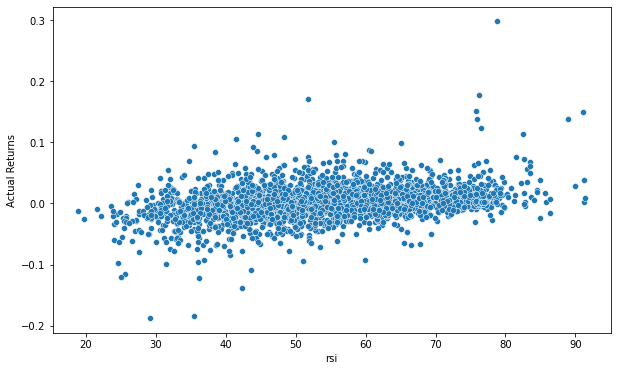

In [8]:
# Evaluate usefulness of signal
plt.figure(figsize=(10,6))
sns.scatterplot(x=RSI_df['rsi'], y=RSI_df['Actual Returns']);

### Bollinger Bands

In [9]:
# Set bollinger band window
bollinger_window = 20

#create new df for bollinger bands
bb_df = signals_df.copy()

# Calculate rolling mean and standard deviation
bb_df['bollinger_mid_band'] = bb_df['Close'].rolling(window=bollinger_window).mean()
bb_df['bollinger_std'] = bb_df['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
bb_df['bollinger_upper_band']  = bb_df['bollinger_mid_band'] + (bb_df['bollinger_std'] * 1)
bb_df['bollinger_lower_band']  = bb_df['bollinger_mid_band'] - (bb_df['bollinger_std'] * 1)

# Calculate bollinger band trading signal
bb_df['bollinger_long'] = np.where(bb_df['Close'] < bb_df['bollinger_lower_band'], 1.0, 0.0)
bb_df['bollinger_short'] = np.where(bb_df['Close'] > bb_df['bollinger_upper_band'], -1.0, 0.0)
bb_df['bollinger_signal'] = bb_df['bollinger_long'] + bb_df['bollinger_short']

# bb_df['bollinger_signal'] = np.where(bb_df['Close'].shift(-1) < bb_df['bollinger_lower_band'], 1.0, 0)



bb_df['bollinger_signal'].value_counts()

 0.0    1273
-1.0     946
 1.0     549
Name: bollinger_signal, dtype: int64

<AxesSubplot:xlabel='Date'>

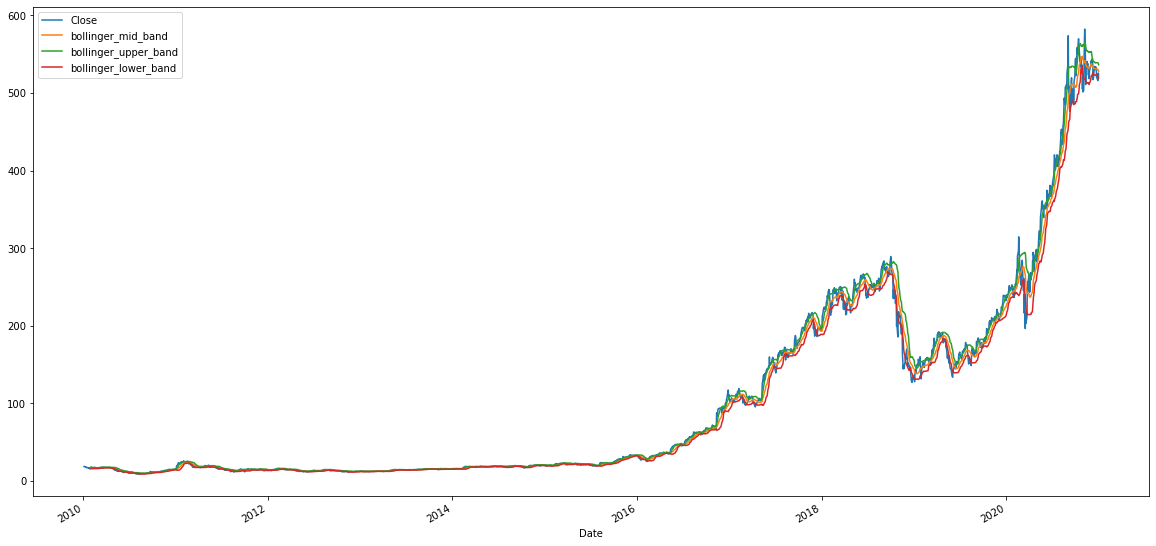

In [10]:
# Plot the Bollinger Bands for closing prices
bb_df[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [11]:
# Calculate the strategy returns and add them to the signals_df DataFrame
bb_df['Strategy Returns'] = bb_df['Actual Returns'] * bb_df['bollinger_signal'].shift()

# Calculate the points in time at which a position should be taken, 1 or -1
bb_df['Entry/Exit'] = bb_df['bollinger_signal'].diff()

# # Visualize exit position relative to close price
bb_df['exit'] = bb_df[bb_df['Entry/Exit'] == 0]['Close']
bb_df['entry'] = bb_df[bb_df['Entry/Exit'] == 1.0]['Close']

# Review the DataFrame
display(bb_df.head())
display(bb_df.tail())

Close  Actual Returns  Target  bollinger_mid_band  \
Date                                                                
2010-01-05  18.760000        0.014603       1                 NaN   
2010-01-06  18.879999        0.006397       0                 NaN   
2010-01-07  18.510000       -0.019597       1                 NaN   
2010-01-08  18.549999        0.002161       0                 NaN   
2010-01-11  18.290001       -0.014016       0                 NaN   

            bollinger_std  bollinger_upper_band  bollinger_lower_band  \
Date                                                                    
2010-01-05            NaN                   NaN                   NaN   
2010-01-06            NaN                   NaN                   NaN   
2010-01-07            NaN                   NaN                   NaN   
2010-01-08            NaN                   NaN                   NaN   
2010-01-11            NaN                   NaN                   NaN   

            bollinger_long  bollinger_short  bollinger_signal  \
Date                                                            
2010-01-05             0.0              0.0               0.0   
2010-01-06             0.0              0.0               0.0   
2010-01-07             0.0              0.0               0.0   
2010-01-08             0.0              0.0               0.0   
2010-01-11             0.0              0.0               0.0   

            Strategy Returns  Entry/Exit       exit  entry  
Date                                                        
2010-01-05               NaN         NaN        NaN    NaN  
2010-01-06               0.0         0.0  18.879999    NaN  
2010-01-07              -0.0         0.0  18.510000    NaN  
2010-01-08               0.0         0.0  18.549999    NaN  
2010-01-11              -0.0         0.0  18.290001    NaN

Close  Actual Returns  Target  bollinger_mid_band  \
Date                                                                 
2020-12-24  519.750000       -0.001191       0          531.126004   
2020-12-28  516.000000       -0.007215       1          530.403503   
2020-12-29  517.729980        0.003353       1          529.487003   
2020-12-30  525.830017        0.015645       0          528.998505   
2020-12-31  522.200012       -0.006903       0          528.019504   

            bollinger_std  bollinger_upper_band  bollinger_lower_band  \
Date                                                                    
2020-12-24       7.989458            539.115462            523.136546   
2020-12-28       8.677546            539.081050            521.725957   
2020-12-29       9.010284            538.497287            520.476719   
2020-12-30       8.925869            537.924374            520.072636   
2020-12-31       8.514492            536.533996            519.505012   

            bollinger_long  bollinger_short  bollinger_signal  \
Date                                                            
2020-12-24             1.0              0.0               1.0   
2020-12-28             1.0              0.0               1.0   
2020-12-29             1.0              0.0               1.0   
2020-12-30             0.0              0.0               0.0   
2020-12-31             0.0              0.0               0.0   

            Strategy Returns  Entry/Exit        exit  entry  
Date                                                         
2020-12-24         -0.001191         0.0  519.750000    NaN  
2020-12-28         -0.007215         0.0  516.000000    NaN  
2020-12-29          0.003353         0.0  517.729980    NaN  
2020-12-30          0.015645        -1.0         NaN    NaN  
2020-12-31         -0.000000         0.0  522.200012    NaN

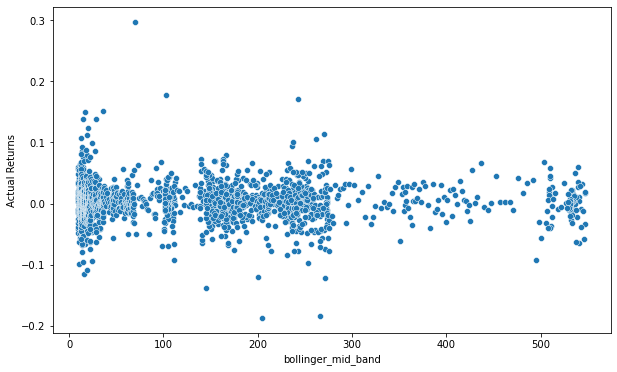

In [12]:
# Evaluate usefulness of signal
plt.figure(figsize=(10,6))
sns.scatterplot(x=bb_df['bollinger_mid_band'], y=bb_df['Actual Returns']);

## EMA

In [13]:
# ema_df = stock_data.loc[:, ["Close"]]

# short_window = 1
# long_window = 10

# # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
# ema_df['fast_close'] = ema_df['Close'].ewm(halflife=short_window).mean()
# ema_df['slow_close'] = ema_df['Close'].ewm(halflife=long_window).mean()

# # Construct a crossover trading signal
# ema_df['crossover_long'] = np.where(ema_df['fast_close'] > ema_df['slow_close'], 1.0, 0.0)
# ema_df['crossover_short'] = np.where(ema_df['fast_close'] < ema_df['slow_close'], -1.0, 0.0)
# ema_df['crossover_signal'] = ema_df['crossover_long'] + ema_df['crossover_short']


# # Generate the short and long moving averages (50 and 100 days, respectively)
# ema_df["SMA50"] = ema_df["Close"].rolling(window=short_window).mean()
# ema_df["SMA100"] = ema_df["Close"].rolling(window=long_window).mean()
# ema_df["Signal"] = 0.0

# # Generate the trading signal 0 or 1,
# # where 0 is when the SMA50 is under the SMA100, and
# # where 1 is when the SMA50 is higher (or crosses over) the SMA100
# ema_df["Signal"][short_window:] = np.where(
#     ema_df["SMA50"][short_window:] > ema_df["SMA100"][short_window:], 1.0, 0.0
# )

# # Calculate the points in time at which a position should be taken, 1 or -1
# ema_df["Entry/Exit"] = ema_df["Signal"].diff()


In [14]:
# Visualize exit position relative to close price
# exit = ema_df[ema_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
#     color='red',
#     legend=False,
#     ylabel='Price in $',
#     width=1000,
#     height=400)

# # Visualize entry position relative to close price
# entry = ema_df[ema_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
#     color='green',
#     legend=False,
#     ylabel='Price in $',
#     width=1000,
#     height=400)

# # Visualize close price for the investment
# security_close = ema_df[['Close']].hvplot(
#     line_color='lightgray',
#     ylabel='Price in $',
#     width=1000,
#     height=400)

# # Visualize moving averages
# moving_avgs = ema_df[['SMA50', 'SMA100']].hvplot(
#     ylabel='Price in $',
#     width=1000,
#     height=400)

# # Overlay plots
# entry_exit_plot = security_close * moving_avgs * entry * exit
# entry_exit_plot.opts(xaxis=None)

## SMA

In [15]:
# Set the windows
short_window = 50
long_window = 100

sma_df = signals_df.copy()

# Generate the short (50 days) and long moving averages(100 days) 
sma_df["SMA50"] = sma_df["Close"].rolling(window=short_window).mean()
sma_df["SMA100"] = sma_df["Close"].rolling(window=long_window).mean()
sma_df["Signal"] = 0

# Generate the trading signal 0 or 1,
# where 0 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
sma_df["Signal"][short_window:] = np.where(
    sma_df["SMA50"][short_window:] > sma_df["SMA100"][short_window:], 1.0, 0
)

# Calculate the points in time at which a position should be taken, 1 or -1
sma_df["Entry/Exit"] = sma_df["Signal"].diff()


# Visualize exit point compared to closing price
exit = sma_df[sma_df['Entry/Exit'] == -1]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in USD $',
    width=1100,
    height=600
)
# Visualize entry point compared to the closing price
entry = sma_df[sma_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in USD $',
    width=1100,
    height=600
)
# Visualize closing price
close_price = sma_df[['Close']].hvplot(
    line_color='lightblue',
    ylabel='Closing Price in USD $',
    width=1100,
    height=600
)
# Visualize moving averages
mv_avgs = sma_df[['SMA50', 'SMA100']].hvplot(
    ylabel='Closing Price in USD $',
    width=1100,
    height=600
)
# Generate the plots
entry_exit_plot = close_price * mv_avgs * entry * exit
entry_exit_plot.opts(xaxis=True)


<ipython-input-15-48e08962634b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sma_df["Signal"][short_window:] = np.where(


:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [16]:
# Calculate SMA10,20,50, and 100
SMA10 = sma_df['Close'].rolling(window = 10).mean()
SMA20 =  sma_df['Close'].rolling(window = 20).mean()
SMA50 =  sma_df['Close'].rolling(window = 50).mean()
SMA100 =  sma_df['Close'].rolling(window = 100).mean()

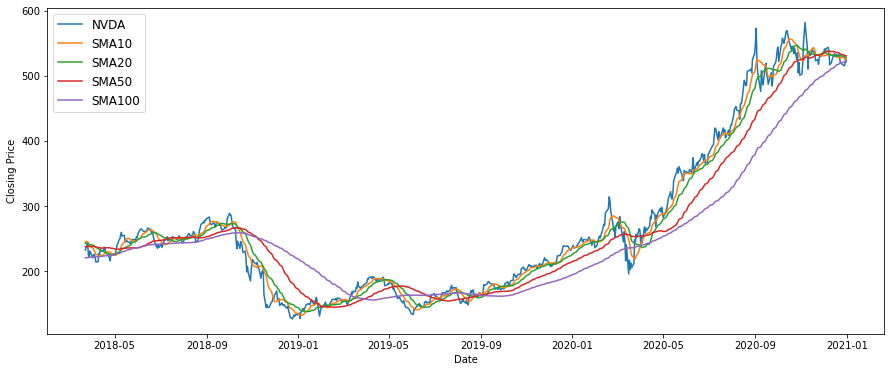

In [17]:

# Visualize the last 700 trading days
plt.figure(figsize=(15, 6))
plt.plot(sma_df['Close'][-700:], label=f'{ticker}')
plt.plot(SMA10[-700:], label='SMA10')
plt.plot(SMA20[-700:], label='SMA20')
plt.plot(SMA50[-700:], label='SMA50')
plt.plot(SMA100[-700:], label='SMA100')
plt.ylabel("Closing Price")
plt.xlabel("Date")
plt.legend(loc='upper left', fontsize=12)

In [18]:
sma_df['Signal'].value_counts()

1.0    2002
0.0     766
Name: Signal, dtype: int64

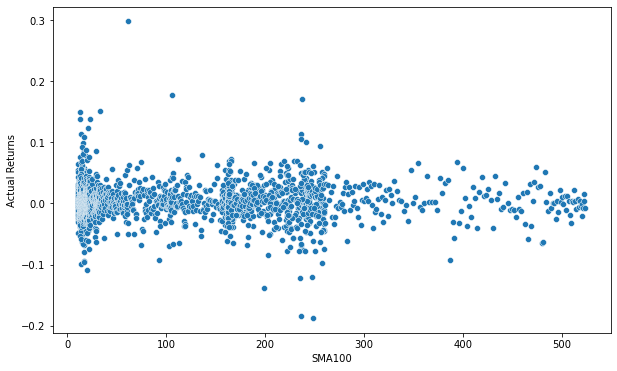

In [19]:
# Evaluate usefulness of signal
plt.figure(figsize=(10,6))
sns.scatterplot(x=sma_df['SMA100'], y=sma_df['Actual Returns']);

## MACD

In [20]:
MACD_df = signals_df.copy()

# Calulate the Short and Long EMA
EMA_short = MACD_df.Close.ewm(span=12, adjust=False).mean()
EMA_long = MACD_df.Close.ewm(span=24, adjust=False).mean()

# Calculate the MACD
MACD = EMA_short - EMA_long

signal = MACD.ewm(span=9, adjust=False).mean()


MACD_df["MACD"] = MACD
MACD_df["Signal"] = signal
MACD_df

def entry_exit(signal):
    Entry = []
    Exit = []
    flag = -1
    
    for i in range(0, len(signal)):
        if signal["MACD"][i] > signal["Signal"][i]:
            Exit.append(np.nan)
            if flag != 1:
                Entry.append(signal["Close"][i])
                flag = 1
            else:
                Entry.append(np.nan)
        elif signal["MACD"][i] < signal["Signal"][i]:
            Entry.append(np.nan)
            if flag != -1:
                Exit.append(signal["Close"][i])
                flag = -1
            else:
                Exit.append(np.nan)
        else:
            Entry.append(np.nan)
            Exit.append(np.nan)
            
    return (Entry, Exit, flag)

data = entry_exit(MACD_df)
MACD_df["Entry_Point"] = data[0]
MACD_df["Exit_Point"] = data[1]
MACD_df["flag"] = data[2]



MACD_df['MACD Entry/Exit'] = MACD_df['Signal'].diff()

MACD_df.where(~MACD_df['Entry_Point'].notna(), 1) 

MACD_df['flag'].value_counts()
MACD_df

Close  Actual Returns  Target      MACD    Signal  \
Date                                                                 
2010-01-05   18.760000        0.014603       1  0.000000  0.000000   
2010-01-06   18.879999        0.006397       0  0.008861  0.001772   
2010-01-07   18.510000       -0.019597       1 -0.011672 -0.000917   
2010-01-08   18.549999        0.002161       0 -0.024560 -0.005645   
2010-01-11   18.290001       -0.014016       0 -0.053489 -0.015214   
...                ...             ...     ...       ...       ...   
2020-12-24  519.750000       -0.001191       0 -1.971676 -1.142696   
2020-12-28  516.000000       -0.007215       1 -2.706989 -1.455554   
2020-12-29  517.729980        0.003353       1 -3.118333 -1.788110   
2020-12-30  525.830017        0.015645       0 -2.802012 -1.990890   
2020-12-31  522.200012       -0.006903       0 -2.789344 -2.150581   

            Entry_Point  Exit_Point  flag  MACD Entry/Exit  
Date                                                        
2010-01-05          NaN         NaN    -1              NaN  
2010-01-06    18.879999         NaN    -1         0.001772  
2010-01-07          NaN       18.51    -1        -0.002689  
2010-01-08          NaN         NaN    -1        -0.004729  
2010-01-11          NaN         NaN    -1        -0.009569  
...                 ...         ...   ...              ...  
2020-12-24          NaN         NaN    -1        -0.207245  
2020-12-28          NaN         NaN    -1        -0.312859  
2020-12-29          NaN         NaN    -1        -0.332556  
2020-12-30          NaN         NaN    -1        -0.202780  
2020-12-31          NaN         NaN    -1        -0.159691  

[2768 rows x 9 columns]

### Compiling Signals

In [21]:
# Compiling Signals
signals = []
    
# # Bollinger Bands
col_name = 'BB_signal'
signals_df[col_name] = bb_df['bollinger_signal']
signals.append(col_name)

# RSI
col_name = 'RSI_signal'
signals_df[col_name] = RSI_df['RSI_signal']
signals.append(col_name)

# # # SMA
col_name = 'SMA_signal'
signals_df[col_name] = sma_df['Signal']
signals.append(col_name)

# # # #EMA
# col_name = 'EMA_signal'
# signals_df[col_name] = ema_df['Entry/Exit']
# signals.append(col_name)

# MACD
col_name = 'MACD_signal'
signals_df[col_name] = MACD_df['Signal']
signals.append(col_name)


signals

['BB_signal', 'RSI_signal', 'SMA_signal', 'MACD_signal']

In [22]:
# Removing nan values
signals_df.dropna(inplace=True)

In [23]:
signals_df[signals+['Target']]

BB_signal  RSI_signal  SMA_signal  MACD_signal  Target
Date                                                              
2010-01-11        0.0        -1.0         0.0    -0.015214       0
2010-01-12        0.0         0.0         0.0    -0.036399       1
2010-01-13        0.0         0.0         0.0    -0.060036       0
2010-01-14        0.0         0.0         0.0    -0.087907       0
2010-01-15        0.0         0.0         0.0    -0.124371       1
...               ...         ...         ...          ...     ...
2020-12-24        1.0         0.0         1.0    -1.142696       0
2020-12-28        1.0         0.0         1.0    -1.455554       1
2020-12-29        1.0         0.0         1.0    -1.788110       1
2020-12-30        0.0         0.0         1.0    -1.990890       0
2020-12-31        0.0         0.0         1.0    -2.150581       0

[2764 rows x 5 columns]

### Visualize Relationship Among Signals

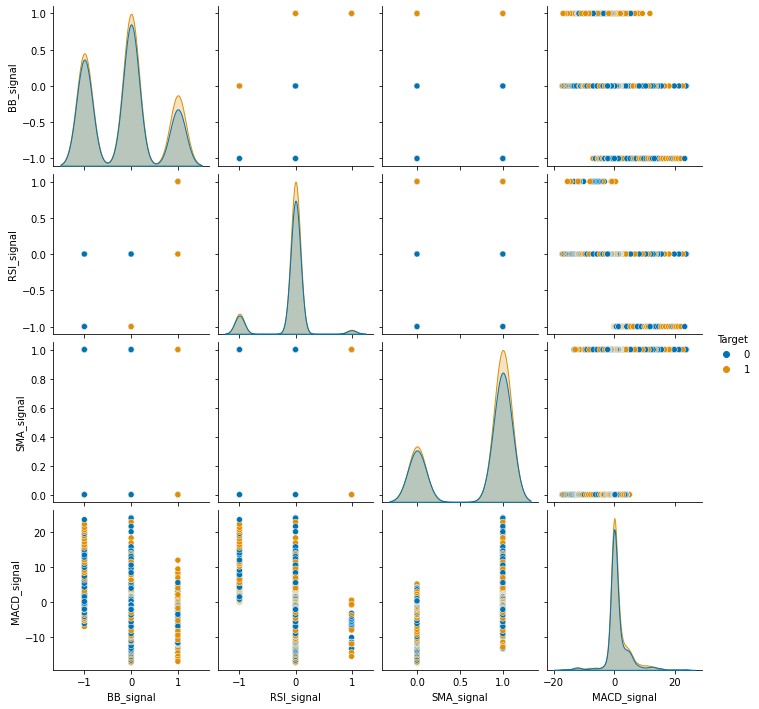

In [24]:
# use pairplots to visualize strength of signals 
sns.pairplot(signals_df[signals+['Target']],hue='Target',palette='colorblind')

## Prepare the Machine Learning Models
---

### Split the data into training and testing datasets

In [25]:
# Assign Target column to a features DataFrame called X
X = signals_df[signals].iloc[:-1]

# Review the DataFrame
X.tail()     

BB_signal  RSI_signal  SMA_signal  MACD_signal
Date                                                      
2020-12-23        1.0         0.0         1.0    -0.935451
2020-12-24        1.0         0.0         1.0    -1.142696
2020-12-28        1.0         0.0         1.0    -1.455554
2020-12-29        1.0         0.0         1.0    -1.788110
2020-12-30        0.0         0.0         1.0    -1.990890

In [26]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df.iloc[:-1]['Target']

# Review the value counts
y.value_counts()

1    1450
0    1313
Name: Target, dtype: int64

In [27]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2010-01-11 00:00:00


In [28]:
# Select the ending period for the training data with an offset of 7 years (90%)
training_end = training_begin + DateOffset(years=7)

# Display the training end date
print(training_end)

2017-01-11 00:00:00


In [29]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.tail()

BB_signal  RSI_signal  SMA_signal  MACD_signal
Date                                                      
2017-01-05        0.0         0.0         1.0     4.880508
2017-01-06        0.0         0.0         1.0     4.599550
2017-01-09        0.0         0.0         1.0     4.362851
2017-01-10        0.0         0.0         1.0     4.143830
2017-01-11        0.0         0.0         1.0     3.918131

In [30]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(days=1):]
y_test = y.loc[training_end+DateOffset(days=1):]

# Review the X_test DataFrame
X_test.head()

BB_signal  RSI_signal  SMA_signal  MACD_signal
Date                                                      
2017-01-12        0.0         0.0         1.0     3.665449
2017-01-13        0.0         0.0         1.0     3.400476
2017-01-17        1.0         0.0         1.0     3.099562
2017-01-18        0.0         0.0         1.0     2.812107
2017-01-19        0.0         0.0         1.0     2.574318

In [31]:
# #scale the data w/ minmax scaler as all obeservations are in range [-1:1]
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# X_train_scaled_df = pd.DataFrame(X_train_scaled,columns=X_train.columns)

In [32]:
X_train.describe().T.round(2)

count  mean   std   min   25%   50%   75%   max
BB_signal    1764.0 -0.10  0.72 -1.00 -1.00  0.00  0.00  1.00
RSI_signal   1764.0 -0.09  0.36 -1.00  0.00  0.00  0.00  1.00
SMA_signal   1764.0  0.66  0.47  0.00  0.00  1.00  1.00  1.00
MACD_signal  1764.0  0.26  0.86 -1.07 -0.11  0.06  0.36  5.51

In [33]:
X_train.describe().T.round(2)

count  mean   std   min   25%   50%   75%   max
BB_signal    1764.0 -0.10  0.72 -1.00 -1.00  0.00  0.00  1.00
RSI_signal   1764.0 -0.09  0.36 -1.00  0.00  0.00  0.00  1.00
SMA_signal   1764.0  0.66  0.47  0.00  0.00  1.00  1.00  1.00
MACD_signal  1764.0  0.26  0.86 -1.07 -0.11  0.06  0.36  5.51

# Logistic Regression

In [34]:
y_train.head()

Date
2010-01-11    0
2010-01-12    1
2010-01-13    0
2010-01-14    0
2010-01-15    1
Name: Target, dtype: int64

In [35]:
X_train.describe()

BB_signal   RSI_signal   SMA_signal  MACD_signal
count  1764.000000  1764.000000  1764.000000  1764.000000
mean     -0.095238    -0.094104     0.664966     0.264987
std       0.723168     0.363055     0.472136     0.857766
min      -1.000000    -1.000000     0.000000    -1.068040
25%      -1.000000     0.000000     0.000000    -0.111805
50%       0.000000     0.000000     1.000000     0.057603
75%       0.000000     0.000000     1.000000     0.357173
max       1.000000     1.000000     1.000000     5.514738

In [36]:
from sklearn.linear_model import LogisticRegression

# Create model
modelLR = LogisticRegression()

# Train model
modelLR.fit(X_train, y_train)

LogisticRegression()

In [37]:
# Predict on train dataset
y_pred_train = modelLR.predict(X_train)
# Predict on test dataset
y_pred = modelLR.predict(X_test)

## Model Evaluation

In [38]:
from sklearn.metrics import accuracy_score

#Scoring the model
print('Model accuracy on training data:', accuracy_score(y_train, y_pred_train))
print('Model accuracy on testing data:', accuracy_score(y_test, y_pred))

# Printing classification report
print(classification_report(y_test, y_pred))

Model accuracy on training data: 0.5130385487528345
Model accuracy on testing data: 0.5265265265265265
              precision    recall  f1-score   support

           0       0.46      0.24      0.32       452
           1       0.55      0.76      0.64       547

    accuracy                           0.53       999
   macro avg       0.50      0.50      0.48       999
weighted avg       0.51      0.53      0.49       999



## Backtesting

In [39]:
# Create a new empty predictions DataFrame.
predictions_df_LR = pd.DataFrame(columns = ['Date','Predicted', 'Target', 'Actual Returns', 'Strategy Returns'])
predictions_df_LR

Empty DataFrame
Columns: [Date, Predicted, Target, Actual Returns, Strategy Returns]
Index: []

In [40]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [41]:
predictions_df_LR['Target'] = y_test
# predictions_df_LR.drop(['Date'], axis=1)

# Add the model predictions to the DataFrame
predictions_df_LR['Predicted'] = y_pred

# Add the actual returns to the DataFrame
predictions_df_LR['Actual Returns'] = signals_df['Actual Returns']
predictions_df_LR

# Add the strategy returns to the DataFrame
predictions_df_LR['Strategy Returns'] = predictions_df_LR['Actual Returns'] * predictions_df_LR['Predicted'].shift()
predictions_df_LR

# add column for cumulative returns
predictions_df_LR['cumulative_rtns'] = (1 + (predictions_df_LR['Strategy Returns'])).cumprod()

# add column for cumulative returns
predictions_df_LR['long_only_rtns'] = (1 + (predictions_df_LR['Actual Returns'])).cumprod()

# Add the strategy returns to the DataFrame
predictions_df_LR['Close'] = signals_df['Close']
predictions_df_LR

# Calculate the points in time at which a position should be taken, 1 or -1
predictions_df_LR['Entry/Exit'] = predictions_df_LR['Predicted'].diff()


predictions_df_LR

Date  Predicted  Target  Actual Returns  Strategy Returns  \
Date                                                                   
2017-01-12  NaN          1       0       -0.016356               NaN   
2017-01-13  NaN          1       0       -0.000097         -0.000097   
2017-01-17  NaN          1       1       -0.022431         -0.022431   
2017-01-18  NaN          1       1        0.018198          0.018198   
2017-01-19  NaN          1       0        0.021467          0.021467   
...         ...        ...     ...             ...               ...   
2020-12-23  NaN          1       0       -0.020259         -0.020259   
2020-12-24  NaN          1       0       -0.001191         -0.001191   
2020-12-28  NaN          1       1       -0.007215         -0.007215   
2020-12-29  NaN          1       1        0.003353          0.003353   
2020-12-30  NaN          0       0        0.015645          0.015645   

            cumulative_rtns  long_only_rtns       Close  Entry/Exit  
Date                                                                 
2017-01-12              NaN        0.983644  103.440002         NaN  
2017-01-13         0.999903        0.983549  103.430000         0.0  
2017-01-17         0.977475        0.961487  101.110001         0.0  
2017-01-18         0.995263        0.978984  102.949997         0.0  
2017-01-19         1.016628        1.000000  105.160004         0.0  
...                     ...             ...         ...         ...  
2020-12-23         3.137851        4.948364  520.369995         0.0  
2020-12-24         3.134113        4.942468  519.750000         0.0  
2020-12-28         3.111500        4.906809  516.000000         0.0  
2020-12-29         3.121932        4.923259  517.729980         0.0  
2020-12-30         3.170775        5.000285  525.830017        -1.0  

[999 rows x 9 columns]

In [42]:
predictions_df_LR['Predicted'].value_counts()

1    760
0    239
Name: Predicted, dtype: int64

In [43]:
# Visualize exit position relative to close price
exit = predictions_df_LR[predictions_df_LR['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize entry position relative to close price
entry = predictions_df_LR[predictions_df_LR['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize close price for the investment
security_close = predictions_df_LR[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay plots
entry_exit_plot = security_close  * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## Strategy Returns

<AxesSubplot:xlabel='Date'>

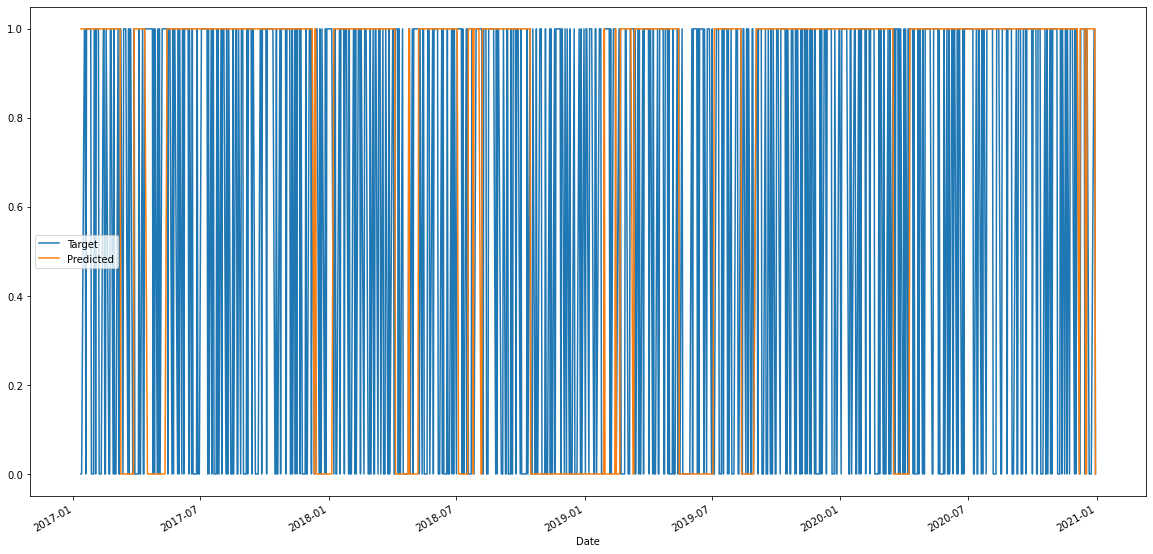

In [44]:
# Plot predicted results vs. actual results
predictions_df_LR[['Target', 'Predicted']].plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

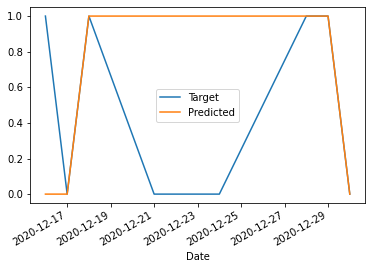

In [45]:
# Plot last 10 records of predicted vs. actual results
predictions_df_LR[['Target', 'Predicted']].tail(10).plot()

From 2017-01-12 to 2020-12-30, this trading algorithm has returned 217.08% vs a long-only return of 400.03%


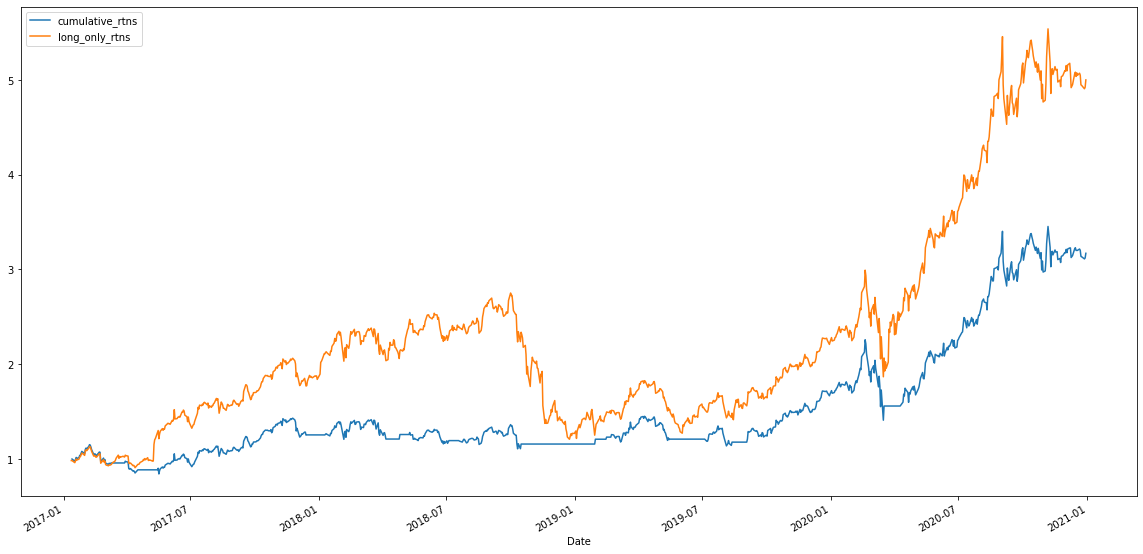

In [46]:
# Plot Cum Returns of Strategy
predictions_df_LR[['cumulative_rtns','long_only_rtns']].plot(figsize=(20,10))

cum_rtn = (predictions_df_LR['cumulative_rtns'].iloc[-1] - 1)*100
long_rtn = (predictions_df_LR['long_only_rtns'].iloc[-1] - 1)*100


series_begin = predictions_df_LR.index.min().date()
series_end = predictions_df_LR.index.max().date()

print(f'From {series_begin} to {series_end}, this trading algorithm has returned {cum_rtn.round(2)}% vs a long-only return of {long_rtn.round(2)}%')

<AxesSubplot:xlabel='Date'>

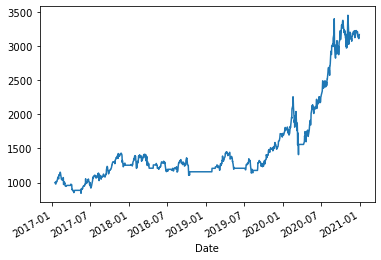

In [47]:
# Set initial capital allocation
initial_capital = 1000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (predictions_df_LR['Strategy Returns'])).cumprod()
cumulative_return_capital.plot()

## ADABoostClassifier

In [48]:
from sklearn.ensemble import AdaBoostClassifier

# Create model
modelADA = AdaBoostClassifier()

# Train model
modelADA.fit(X_train, y_train)

AdaBoostClassifier()

In [49]:
# Predict on train dataset
y_pred_train = modelADA.predict(X_train)
# Predict on test dataset
y_pred = modelADA.predict(X_test)

In [50]:
#Scoring the model
print('Model accuracy on training data:', accuracy_score(y_train, y_pred_train))
print('Model accuracy on testing data:', accuracy_score(y_test, y_pred))

# Printing classification report
print(classification_report(y_test, y_pred))

Model accuracy on training data: 0.576530612244898
Model accuracy on testing data: 0.5155155155155156
              precision    recall  f1-score   support

           0       0.46      0.42      0.44       452
           1       0.55      0.60      0.57       547

    accuracy                           0.52       999
   macro avg       0.51      0.51      0.51       999
weighted avg       0.51      0.52      0.51       999



## Backtesting

In [51]:
# Create a new empty predictions DataFrame.
predictions_df_ADA = pd.DataFrame(columns = ['Date','Predicted', 'Target', 'Actual Returns', 'Strategy Returns'])
predictions_df_ADA

Empty DataFrame
Columns: [Date, Predicted, Target, Actual Returns, Strategy Returns]
Index: []

In [52]:
predictions_df_ADA['Date'] = y_test
predictions_df_ADA.drop(columns=['Date'])

# Add the model predictions to the DataFrame
predictions_df_ADA['Predicted'] = y_pred


# Add the model predictions to the DataFrame
predictions_df_ADA['Target']=signals_df['Target']
predictions_df_ADA

# Add the actual returns to the DataFrame
predictions_df_ADA['Actual Returns'] = signals_df['Actual Returns']
predictions_df_ADA

# Add the strategy returns to the DataFrame
predictions_df_ADA['Strategy Returns'] = predictions_df_ADA['Actual Returns'] * predictions_df_ADA['Predicted'].shift()
predictions_df_ADA

# add column for cumulative returns
predictions_df_ADA['cumulative_rtns'] = (1 + (predictions_df_ADA['Strategy Returns'])).cumprod()

# add column for cumulative returns
predictions_df_ADA['long_only_rtns'] = (1 + (predictions_df_ADA['Actual Returns'])).cumprod()

# Add the strategy returns to the DataFrame
predictions_df_ADA['Close'] = signals_df['Close']
predictions_df_ADA

# Calculate the points in time at which a position should be taken, 1 or -1
predictions_df_ADA['Entry/Exit'] = predictions_df_ADA['Predicted'].diff()


predictions_df_ADA

Date  Predicted  Target  Actual Returns  Strategy Returns  \
Date                                                                    
2017-01-12     0          1       0       -0.016356               NaN   
2017-01-13     0          1       0       -0.000097         -0.000097   
2017-01-17     1          1       1       -0.022431         -0.022431   
2017-01-18     1          1       1        0.018198          0.018198   
2017-01-19     0          1       0        0.021467          0.021467   
...          ...        ...     ...             ...               ...   
2020-12-23     0          1       0       -0.020259         -0.000000   
2020-12-24     0          1       0       -0.001191         -0.001191   
2020-12-28     1          1       1       -0.007215         -0.007215   
2020-12-29     1          1       1        0.003353          0.003353   
2020-12-30     0          1       0        0.015645          0.015645   

            cumulative_rtns  long_only_rtns       Close  Entry/Exit  
Date                                                                 
2017-01-12              NaN        0.983644  103.440002         NaN  
2017-01-13         0.999903        0.983549  103.430000         0.0  
2017-01-17         0.977475        0.961487  101.110001         0.0  
2017-01-18         0.995263        0.978984  102.949997         0.0  
2017-01-19         1.016628        1.000000  105.160004         0.0  
...                     ...             ...         ...         ...  
2020-12-23         2.524568        4.948364  520.369995         1.0  
2020-12-24         2.521560        4.942468  519.750000         0.0  
2020-12-28         2.503367        4.906809  516.000000         0.0  
2020-12-29         2.511760        4.923259  517.729980         0.0  
2020-12-30         2.551057        5.000285  525.830017         0.0  

[999 rows x 9 columns]

In [53]:
# Visualize exit position relative to close price
exit = predictions_df_ADA[predictions_df_ADA['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize entry position relative to close price
entry = predictions_df_ADA[predictions_df_ADA['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize close price for the investment
security_close = predictions_df_ADA[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay plots
entry_exit_plot = security_close  * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## Strategy Returns

<AxesSubplot:xlabel='Date'>

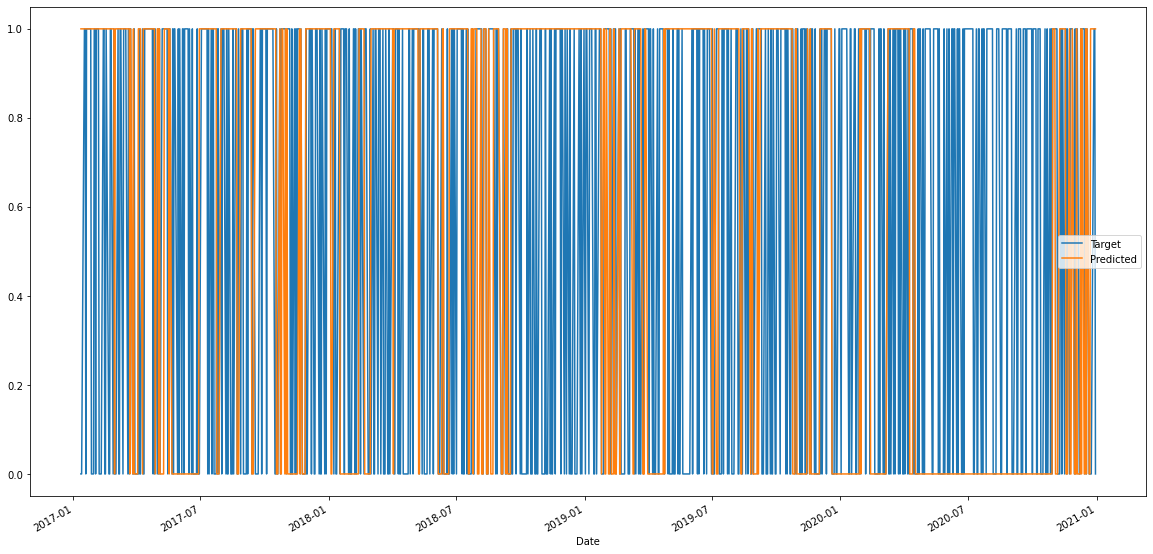

In [54]:
# Plot predicted results vs. actual results
predictions_df_ADA[['Target', 'Predicted']].plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

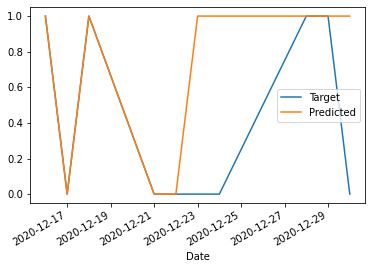

In [55]:
# Plot last 10 records of predicted vs. actual results
predictions_df_ADA[['Target', 'Predicted']].tail(10).plot()

From 2017-01-12 to 2020-12-30, this trading algorithm has returned 155.11% vs a long-only return of 400.03%


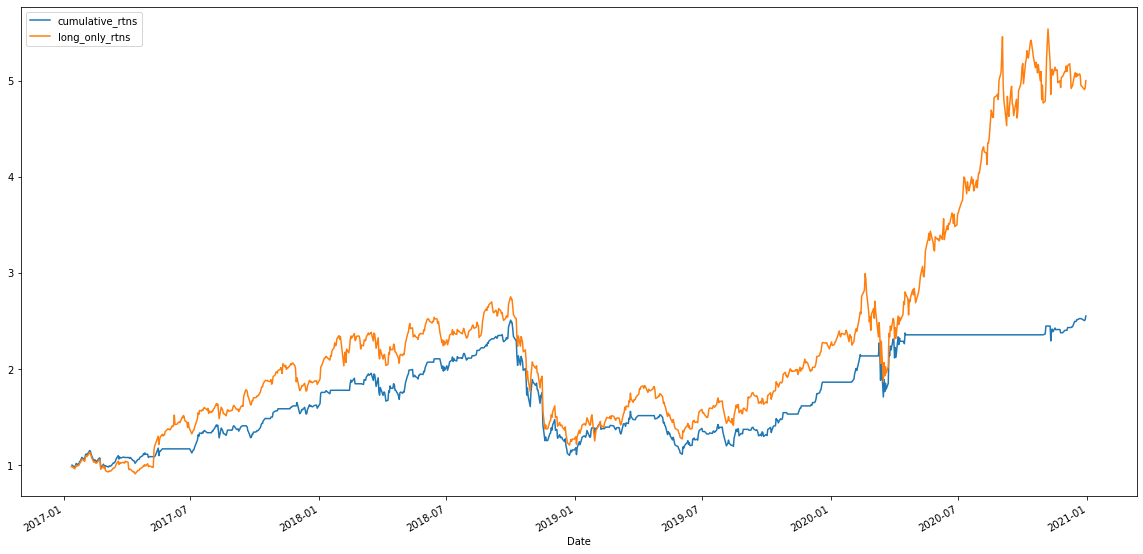

In [56]:
# Plot Cum Returns of Strategy
predictions_df_ADA[['cumulative_rtns','long_only_rtns']].plot(figsize=(20,10))

cum_rtn = (predictions_df_ADA['cumulative_rtns'].iloc[-1] - 1)*100
long_rtn = (predictions_df_ADA['long_only_rtns'].iloc[-1] - 1)*100

series_begin = predictions_df_ADA.index.min().date()
series_end = predictions_df_ADA.index.max().date()

print(f'From {series_begin} to {series_end}, this trading algorithm has returned {cum_rtn.round(2)}% vs a long-only return of {long_rtn.round(2)}%')

<AxesSubplot:xlabel='Date'>

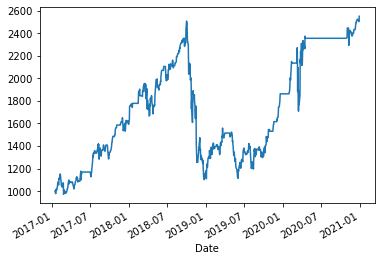

In [57]:
# Set initial capital allocation
initial_capital = 1000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (predictions_df_ADA['Strategy Returns'])).cumprod()
cumulative_return_capital.plot()

# DecisionTree Classifier

In [58]:
from sklearn.tree import DecisionTreeClassifier

# Create model
model = DecisionTreeClassifier()

# Train model
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [59]:
# Predict on train dataset
y_pred_train = model.predict(X_train)
# Predict on test dataset
y_pred = model.predict(X_test)

In [60]:
#Scoring the model
print('Model accuracy on training data:', accuracy_score(y_train, y_pred_train))
print('Model accuracy on testing data:', accuracy_score(y_test, y_pred))

# Printing classification report
print(classification_report(y_test, y_pred))

Model accuracy on training data: 1.0
Model accuracy on testing data: 0.5345345345345346
              precision    recall  f1-score   support

           0       0.48      0.38      0.42       452
           1       0.56      0.66      0.61       547

    accuracy                           0.53       999
   macro avg       0.52      0.52      0.52       999
weighted avg       0.53      0.53      0.53       999



## Backtesting

In [61]:
# Create a new empty predictions DataFrame.
predictions_df_DT = pd.DataFrame(columns = ['Date','Predicted', 'Target', 'Actual Returns', 'Strategy Returns'])
predictions_df_DT

Empty DataFrame
Columns: [Date, Predicted, Target, Actual Returns, Strategy Returns]
Index: []

In [62]:
predictions_df_DT['Date'] = y_test
predictions_df_DT.drop(columns=['Date'])

# Add the model predictions to the DataFrame
predictions_df_DT['Predicted'] = y_pred


# Add the model predictions to the DataFrame
predictions_df_DT['Target']=signals_df['Target']
predictions_df_DT

# Add the actual returns to the DataFrame
predictions_df_DT['Actual Returns'] = signals_df['Actual Returns']
predictions_df_DT

# Add the strategy returns to the DataFrame
predictions_df_DT['Strategy Returns'] = predictions_df_DT['Actual Returns'] * predictions_df_DT['Predicted'].shift()
predictions_df_DT

# add column for cumulative returns
predictions_df_DT['cumulative_rtns'] = (1 + (predictions_df_DT['Strategy Returns'])).cumprod()

# add column for cumulative returns
predictions_df_DT['long_only_rtns'] = (1 + (predictions_df_DT['Actual Returns'])).cumprod()

# Add the strategy returns to the DataFrame
predictions_df_DT['Close'] = signals_df['Close']
predictions_df_DT

# Calculate the points in time at which a position should be taken, 1 or -1
predictions_df_DT['Entry/Exit'] = predictions_df_DT['Predicted'].diff()


predictions_df_DT

Date  Predicted  Target  Actual Returns  Strategy Returns  \
Date                                                                    
2017-01-12     0          0       0       -0.016356               NaN   
2017-01-13     0          0       0       -0.000097         -0.000000   
2017-01-17     1          0       1       -0.022431         -0.000000   
2017-01-18     1          0       1        0.018198          0.000000   
2017-01-19     0          0       0        0.021467          0.000000   
...          ...        ...     ...             ...               ...   
2020-12-23     0          1       0       -0.020259         -0.000000   
2020-12-24     0          1       0       -0.001191         -0.001191   
2020-12-28     1          1       1       -0.007215         -0.007215   
2020-12-29     1          1       1        0.003353          0.003353   
2020-12-30     0          1       0        0.015645          0.015645   

            cumulative_rtns  long_only_rtns       Close  Entry/Exit  
Date                                                                 
2017-01-12              NaN        0.983644  103.440002         NaN  
2017-01-13         1.000000        0.983549  103.430000         0.0  
2017-01-17         1.000000        0.961487  101.110001         0.0  
2017-01-18         1.000000        0.978984  102.949997         0.0  
2017-01-19         1.000000        1.000000  105.160004         0.0  
...                     ...             ...         ...         ...  
2020-12-23         6.544961        4.948364  520.369995         1.0  
2020-12-24         6.537163        4.942468  519.750000         0.0  
2020-12-28         6.489997        4.906809  516.000000         0.0  
2020-12-29         6.511756        4.923259  517.729980         0.0  
2020-12-30         6.613634        5.000285  525.830017         0.0  

[999 rows x 9 columns]

In [63]:
# Visualize exit position relative to close price
exit = predictions_df_DT[predictions_df_DT['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize entry position relative to close price
entry = predictions_df_DT[predictions_df_DT['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize close price for the investment
security_close = predictions_df_DT[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay plots
entry_exit_plot = security_close  * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## Strategy Returns

<AxesSubplot:xlabel='Date'>

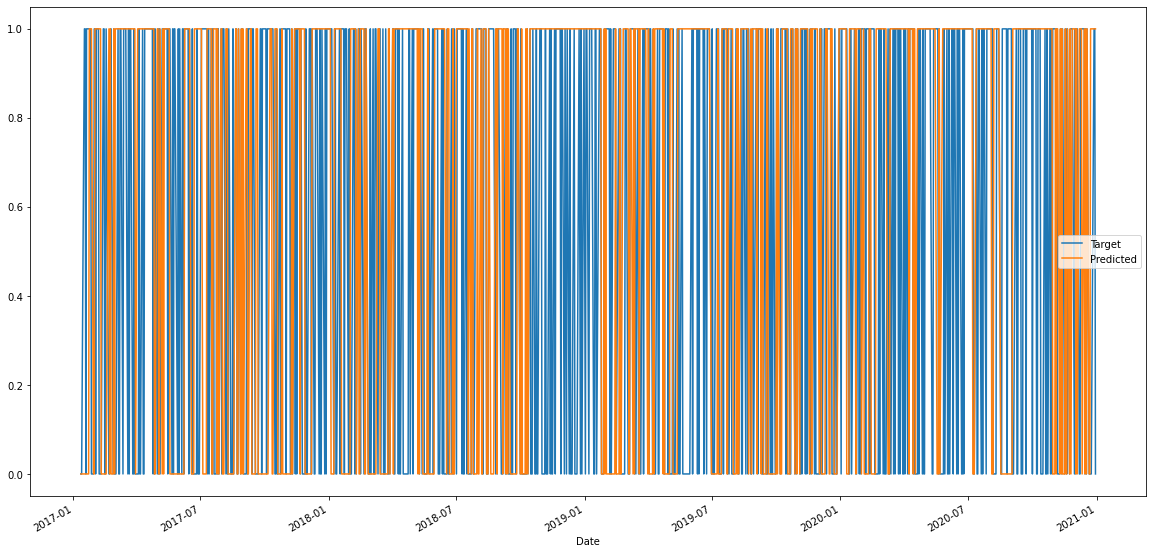

In [64]:
# Plot predicted results vs. actual results
predictions_df_DT[['Target', 'Predicted']].plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

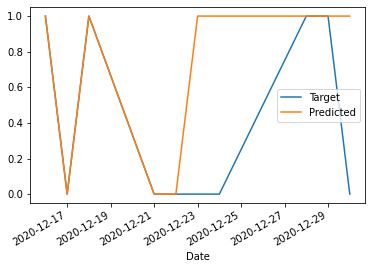

In [65]:
# Plot last 10 records of predicted vs. actual results
predictions_df_DT[['Target', 'Predicted']].tail(10).plot()

From 2017-01-12 to 2020-12-30, this trading algorithm has returned 561.36% vs a long-only return of 400.03%


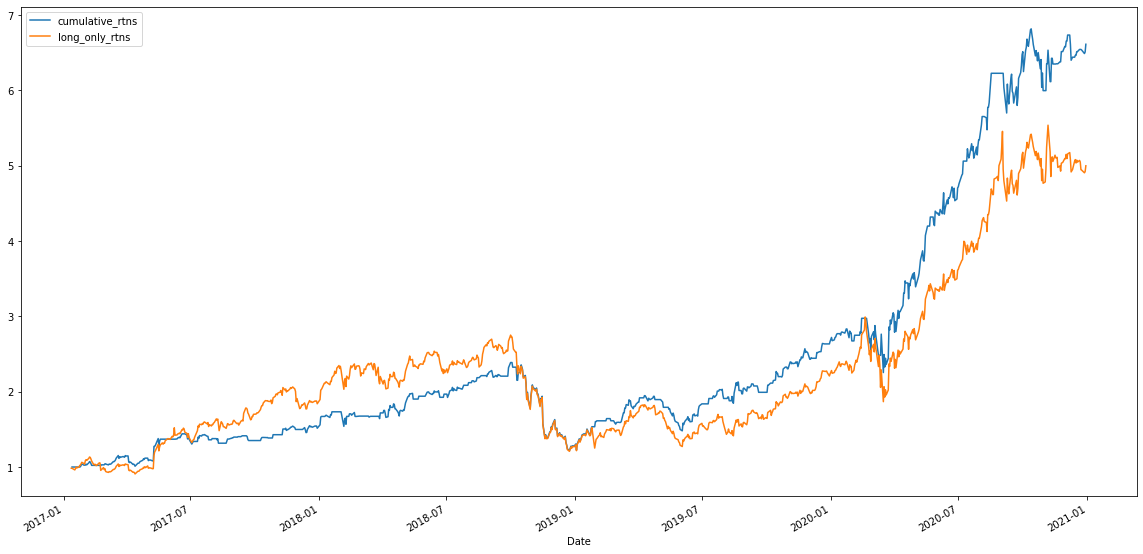

In [66]:
# Plot Cum Returns of Strategy
predictions_df_DT[['cumulative_rtns','long_only_rtns']].plot(figsize=(20,10))

cum_rtn = (predictions_df_DT['cumulative_rtns'].iloc[-1] - 1)*100
long_rtn = (predictions_df_DT['long_only_rtns'].iloc[-1] - 1)*100

series_begin = predictions_df_DT.index.min().date()
series_end = predictions_df_DT.index.max().date()

print(f'From {series_begin} to {series_end}, this trading algorithm has returned {cum_rtn.round(2)}% vs a long-only return of {long_rtn.round(2)}%')

<AxesSubplot:xlabel='Date'>

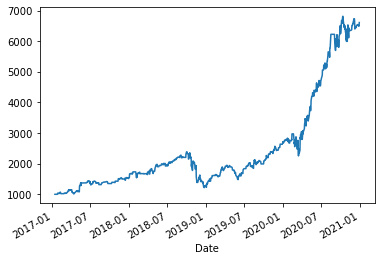

In [67]:
# Set initial capital allocation
initial_capital = 1000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (predictions_df_DT['Strategy Returns'])).cumprod()
cumulative_return_capital.plot()

# Gradient Boosting Classifier

In [68]:
from sklearn.ensemble import GradientBoostingClassifier

# Create model
model = GradientBoostingClassifier()

# Train model
model.fit(X_train, y_train)

GradientBoostingClassifier()

In [69]:
# Predict on train dataset
y_pred_train = model.predict(X_train)
# Predict on test dataset
y_pred = model.predict(X_test)

In [70]:
#Scoring the model
print('Model accuracy on training data:', accuracy_score(y_train, y_pred_train))
print('Model accuracy on testing data:', accuracy_score(y_test, y_pred))

# Printing classification report
print(classification_report(y_test, y_pred))

Model accuracy on training data: 0.6848072562358276
Model accuracy on testing data: 0.5295295295295295
              precision    recall  f1-score   support

           0       0.48      0.42      0.45       452
           1       0.56      0.62      0.59       547

    accuracy                           0.53       999
   macro avg       0.52      0.52      0.52       999
weighted avg       0.52      0.53      0.53       999



## Backtesting

In [71]:
# Create a new empty predictions DataFrame.
predictions_df_GBC = pd.DataFrame(columns = ['Date','Predicted', 'Target', 'Actual Returns', 'Strategy Returns'])
predictions_df_GBC

Empty DataFrame
Columns: [Date, Predicted, Target, Actual Returns, Strategy Returns]
Index: []

In [72]:
predictions_df_GBC['Date'] = y_test
predictions_df_GBC.drop(columns=['Date'])

# Add the model predictions to the DataFrame
predictions_df_GBC['Predicted'] = y_pred


# Add the model predictions to the DataFrame
predictions_df_GBC['Target']=signals_df['Target']
predictions_df_GBC

# Add the actual returns to the DataFrame
predictions_df_GBC['Actual Returns'] = signals_df['Actual Returns']
predictions_df_GBC

# Add the strategy returns to the DataFrame
predictions_df_GBC['Strategy Returns'] = predictions_df_GBC['Actual Returns'] * predictions_df_GBC['Predicted'].shift()
predictions_df_GBC

# add column for cumulative returns
predictions_df_GBC['cumulative_rtns'] = (1 + (predictions_df_GBC['Strategy Returns'])).cumprod()

# add column for cumulative returns
predictions_df_GBC['long_only_rtns'] = (1 + (predictions_df_GBC['Actual Returns'])).cumprod()

# Add the strategy returns to the DataFrame
predictions_df_GBC['Close'] = signals_df['Close']
predictions_df_GBC

# Calculate the points in time at which a position should be taken, 1 or -1
predictions_df_GBC['Entry/Exit'] = predictions_df_GBC['Predicted'].diff()


predictions_df_GBC

Date  Predicted  Target  Actual Returns  Strategy Returns  \
Date                                                                    
2017-01-12     0          1       0       -0.016356               NaN   
2017-01-13     0          0       0       -0.000097         -0.000097   
2017-01-17     1          1       1       -0.022431         -0.000000   
2017-01-18     1          1       1        0.018198          0.018198   
2017-01-19     0          1       0        0.021467          0.021467   
...          ...        ...     ...             ...               ...   
2020-12-23     0          1       0       -0.020259         -0.000000   
2020-12-24     0          1       0       -0.001191         -0.001191   
2020-12-28     1          1       1       -0.007215         -0.007215   
2020-12-29     1          1       1        0.003353          0.003353   
2020-12-30     0          1       0        0.015645          0.015645   

            cumulative_rtns  long_only_rtns       Close  Entry/Exit  
Date                                                                 
2017-01-12              NaN        0.983644  103.440002         NaN  
2017-01-13         0.999903        0.983549  103.430000        -1.0  
2017-01-17         0.999903        0.961487  101.110001         1.0  
2017-01-18         1.018100        0.978984  102.949997         0.0  
2017-01-19         1.039955        1.000000  105.160004         0.0  
...                     ...             ...         ...         ...  
2020-12-23         4.061008        4.948364  520.369995         1.0  
2020-12-24         4.056170        4.942468  519.750000         0.0  
2020-12-28         4.026905        4.906809  516.000000         0.0  
2020-12-29         4.040405        4.923259  517.729980         0.0  
2020-12-30         4.103619        5.000285  525.830017         0.0  

[999 rows x 9 columns]

In [73]:
# Visualize exit position relative to close price
exit = predictions_df_GBC[predictions_df_GBC['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize entry position relative to close price
entry = predictions_df_GBC[predictions_df_GBC['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize close price for the investment
security_close = predictions_df_GBC[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay plots
entry_exit_plot = security_close  * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## Strategy Returns

<AxesSubplot:xlabel='Date'>

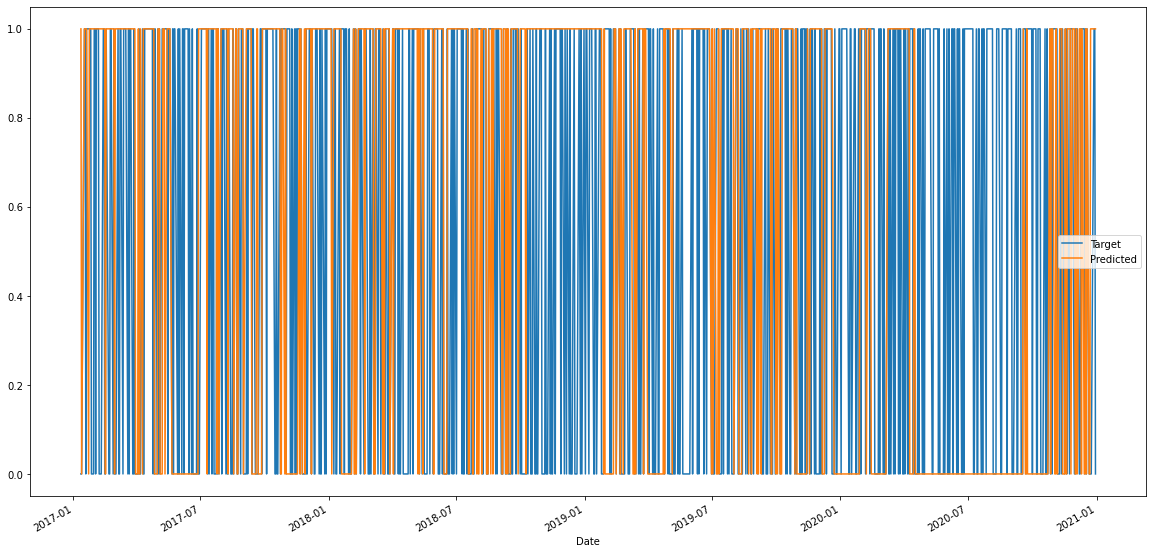

In [74]:
# Plot predicted results vs. actual results
predictions_df_GBC[['Target', 'Predicted']].plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

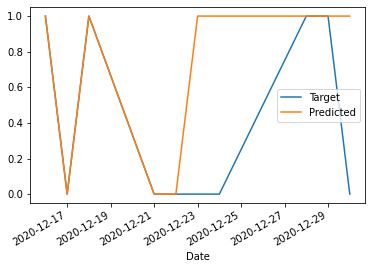

In [75]:
# Plot last 10 records of predicted vs. actual results
predictions_df_GBC[['Target', 'Predicted']].tail(10).plot()

From 2017-01-12 to 2020-12-30, this trading algorithm has returned 310.36% vs a long-only return of 400.03%


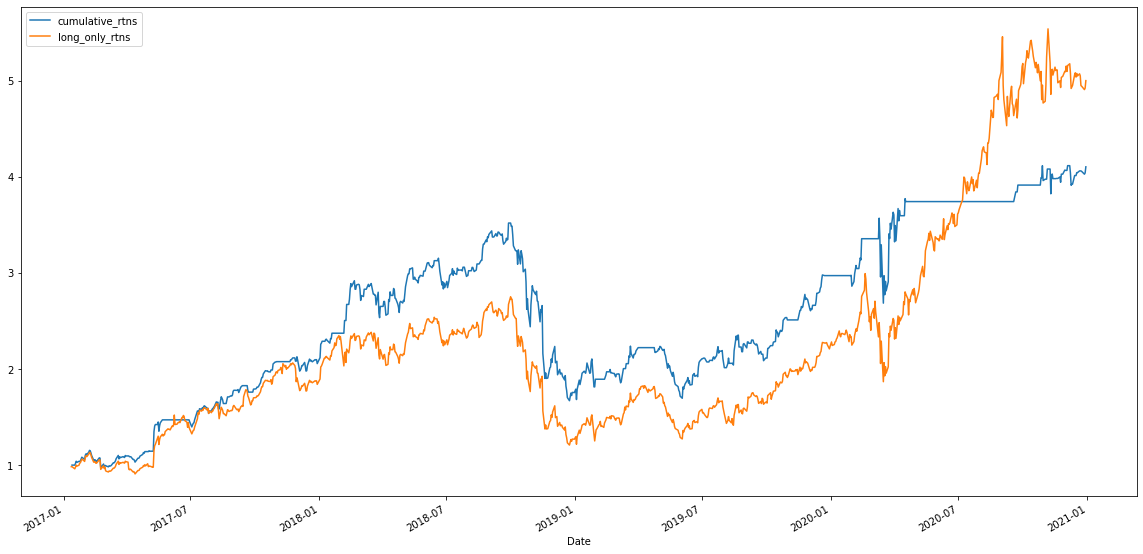

In [76]:
# Plot Cum Returns of Strategy
predictions_df_GBC[['cumulative_rtns','long_only_rtns']].plot(figsize=(20,10))

cum_rtn = (predictions_df_GBC['cumulative_rtns'].iloc[-1] - 1)*100
long_rtn = (predictions_df_GBC['long_only_rtns'].iloc[-1] - 1)*100

series_begin = predictions_df_GBC.index.min().date()
series_end = predictions_df_GBC.index.max().date()

print(f'From {series_begin} to {series_end}, this trading algorithm has returned {cum_rtn.round(2)}% vs a long-only return of {long_rtn.round(2)}%')

<AxesSubplot:xlabel='Date'>

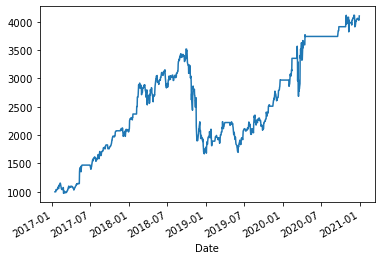

In [77]:
# Set initial capital allocation
initial_capital = 1000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (predictions_df_GBC['Strategy Returns'])).cumprod()
cumulative_return_capital.plot()

# Random Forest

In [78]:
from sklearn.ensemble import RandomForestClassifier

# Create model
model = RandomForestClassifier()

# Train model
model.fit(X_train, y_train)

RandomForestClassifier()

In [79]:
# Predict on train dataset
y_pred_train = model.predict(X_train)
# Predict on test dataset
y_pred = model.predict(X_test)

In [80]:
#Scoring the model
print('Model accuracy on training data:', accuracy_score(y_train, y_pred_train))
print('Model accuracy on testing data:', accuracy_score(y_test, y_pred))

# Printing classification report
print(classification_report(y_test, y_pred))

Model accuracy on training data: 1.0
Model accuracy on testing data: 0.5245245245245245
              precision    recall  f1-score   support

           0       0.47      0.40      0.43       452
           1       0.56      0.63      0.59       547

    accuracy                           0.52       999
   macro avg       0.51      0.51      0.51       999
weighted avg       0.52      0.52      0.52       999



## Backtesting

In [81]:
# Create a new empty predictions DataFrame.
predictions_df_RFC = pd.DataFrame(columns = ['Date','Predicted', 'Target', 'Actual Returns', 'Strategy Returns'])
predictions_df_RFC

Empty DataFrame
Columns: [Date, Predicted, Target, Actual Returns, Strategy Returns]
Index: []

In [91]:
predictions_df_RFC['Date'] = y_test
predictions_df_RFC.drop(columns=['Date'])

# Add the model predictions to the DataFrame
predictions_df_RFC['Predicted'] = y_pred


# Add the model predictions to the DataFrame
predictions_df_RFC['Target']=signals_df['Target']
predictions_df_RFC

# Add the actual returns to the DataFrame
predictions_df_RFC['Actual Returns'] = signals_df['Actual Returns']
predictions_df_RFC

# Add the strategy returns to the DataFrame
predictions_df_RFC['Strategy Returns'] = predictions_df_RFC['Actual Returns'] * predictions_df_RFC['Predicted'].shift()
predictions_df_RFC

# add column for cumulative returns
predictions_df_RFC['cumulative_rtns'] = (1 + (predictions_df_RFC['Strategy Returns'])).cumprod()

# add column for cumulative returns
predictions_df_RFC['long_only_rtns'] = (1 + (predictions_df_RFC['Actual Returns'])).cumprod()

# Add the strategy returns to the DataFrame
predictions_df_RFC['Close'] = signals_df['Close']
predictions_df_RFC

# Calculate the points in time at which a position should be taken, 1 or -1
predictions_df_RFC['Entry/Exit'] = predictions_df_RFC['Predicted'].diff()


predictions_df_RFC

Date  Predicted  Target  Actual Returns  Strategy Returns  \
Date                                                                    
2017-01-12     0          0       0       -0.016356               NaN   
2017-01-13     0          0       0       -0.000097         -0.000000   
2017-01-17     1          1       1       -0.022431         -0.000000   
2017-01-18     1          0       1        0.018198          0.018198   
2017-01-19     0          0       0        0.021467          0.000000   
...          ...        ...     ...             ...               ...   
2020-12-23     0          1       0       -0.020259         -0.000000   
2020-12-24     0          1       0       -0.001191         -0.001191   
2020-12-28     1          1       1       -0.007215         -0.007215   
2020-12-29     1          1       1        0.003353          0.003353   
2020-12-30     0          1       0        0.015645          0.015645   

            cumulative_rtns  long_only_rtns       Close  Entry/Exit  
Date                                                                 
2017-01-12              NaN        0.983644  103.440002         NaN  
2017-01-13         1.000000        0.983549  103.430000         0.0  
2017-01-17         1.000000        0.961487  101.110001         1.0  
2017-01-18         1.018198        0.978984  102.949997        -1.0  
2017-01-19         1.018198        1.000000  105.160004         0.0  
...                     ...             ...         ...         ...  
2020-12-23         5.156896        4.948364  520.369995         1.0  
2020-12-24         5.150752        4.942468  519.750000         0.0  
2020-12-28         5.113590        4.906809  516.000000         0.0  
2020-12-29         5.130734        4.923259  517.729980         0.0  
2020-12-30         5.211006        5.000285  525.830017         0.0  

[999 rows x 9 columns]

In [92]:
# Visualize exit position relative to close price
exit = predictions_df_RFC[predictions_df_RFC['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize entry position relative to close price
entry = predictions_df_RFC[predictions_df_RFC['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize close price for the investment
security_close = predictions_df_RFC[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay plots
entry_exit_plot = security_close  * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## Strategy Returns

<AxesSubplot:xlabel='Date'>

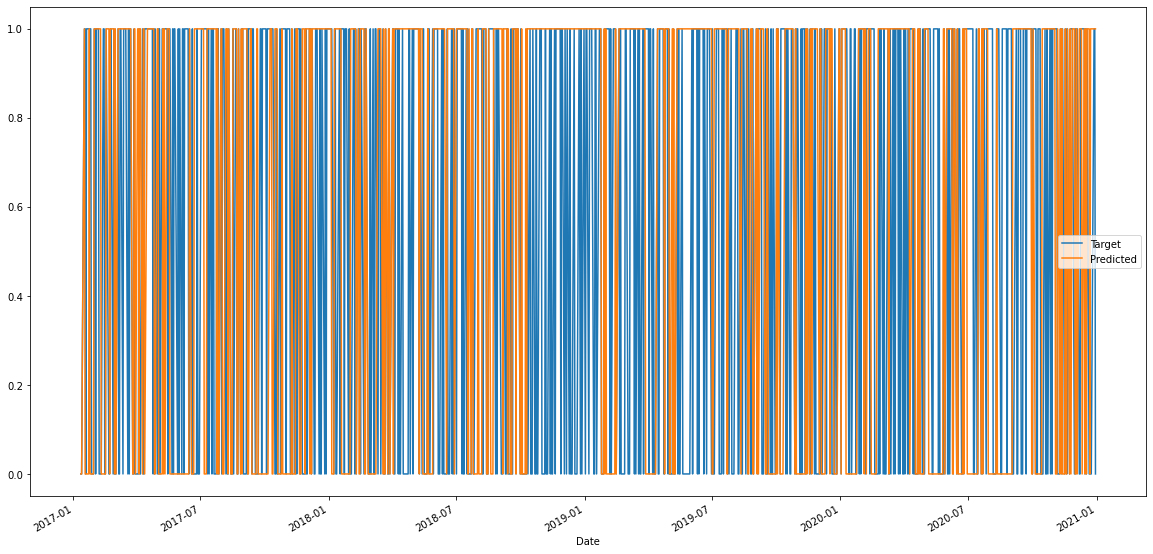

In [93]:
# Plot predicted results vs. actual results
predictions_df_RFC[['Target', 'Predicted']].plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

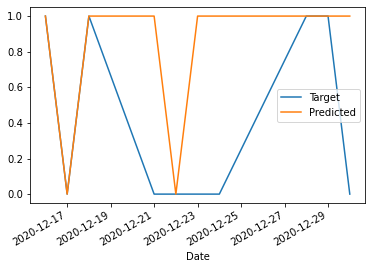

In [94]:
# Plot last 10 records of predicted vs. actual results
predictions_df_RFC[['Target', 'Predicted']].tail(10).plot()

From 2017-01-12 to 2020-12-30, this trading algorithm has returned 421.1% vs a long-only return of 400.03%


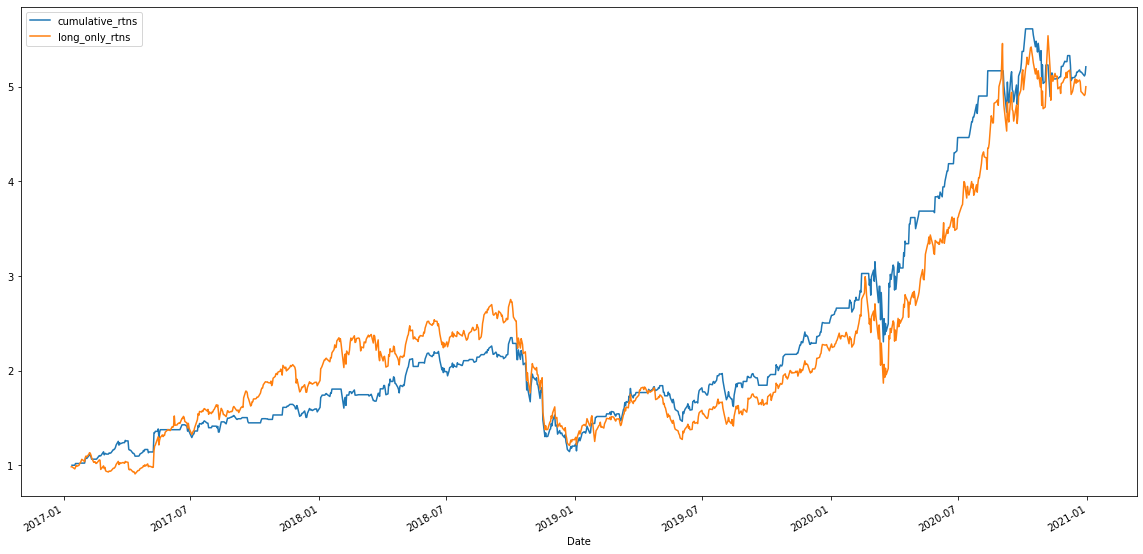

In [95]:
# Plot Cum Returns of Strategy
predictions_df_RFC[['cumulative_rtns','long_only_rtns']].plot(figsize=(20,10))

cum_rtn = (predictions_df_RFC['cumulative_rtns'].iloc[-1] - 1)*100
long_rtn = (predictions_df_RFC['long_only_rtns'].iloc[-1] - 1)*100

series_begin = predictions_df_RFC.index.min().date()
series_end = predictions_df_RFC.index.max().date()

print(f'From {series_begin} to {series_end}, this trading algorithm has returned {cum_rtn.round(2)}% vs a long-only return of {long_rtn.round(2)}%')

<AxesSubplot:xlabel='Date'>

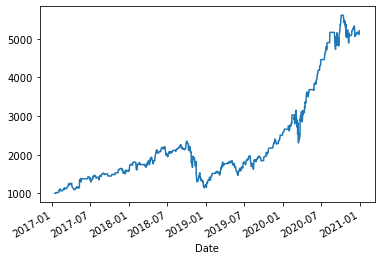

In [96]:
# Set initial capital allocation
initial_capital = 1000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (predictions_df_RFC['Strategy Returns'])).cumprod()
cumulative_return_capital.plot()

# Evaluation
___

## Prep Evaluation Metrics Dataframe

In [97]:
# Prepare DataFrame for metrics
metrics = [
    'Annual Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',]

columns = ['Long Only', 'Logistic Regression', 'RandomForest', 'Gradient Boosting', 'Decision Tree', 'ADABoost']

# Initialize the DataFrame with index set to evaluation metrics and column = trading staregy
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
portfolio_evaluation_df

Long Only Logistic Regression RandomForest  \
Annual Return            NaN                 NaN          NaN   
Cumulative Returns       NaN                 NaN          NaN   
Annual Volatility        NaN                 NaN          NaN   
Sharpe Ratio             NaN                 NaN          NaN   

                   Gradient Boosting Decision Tree ADABoost  
Annual Return                    NaN           NaN      NaN  
Cumulative Returns               NaN           NaN      NaN  
Annual Volatility                NaN           NaN      NaN  
Sharpe Ratio                     NaN           NaN      NaN

## Calculate and Assign Portfolio Metrics

In [98]:
# Calculate cumulative return
portfolio_evaluation_df.loc['Cumulative Returns']['Long Only'] = (predictions_df_LR['long_only_rtns'].iloc[-1] - 1)*100
portfolio_evaluation_df.loc['Cumulative Returns']['Logistic Regression'] = (predictions_df_LR['cumulative_rtns'].iloc[-1] - 1)*100
portfolio_evaluation_df.loc['Cumulative Returns']['RandomForest'] = (predictions_df_RFC['cumulative_rtns'].iloc[-1] - 1)*100
portfolio_evaluation_df.loc['Cumulative Returns']['Gradient Boosting'] = (predictions_df_GBC['cumulative_rtns'].iloc[-1] - 1)*100
portfolio_evaluation_df.loc['Cumulative Returns']['Decision Tree'] = (predictions_df_DT['cumulative_rtns'].iloc[-1] - 1)*100
portfolio_evaluation_df.loc['Cumulative Returns']['ADABoost'] = (predictions_df_ADA['cumulative_rtns'].iloc[-1] - 1)*100


# # Calculate annualized return
portfolio_evaluation_df.loc['Annual Return']['Long Only'] = (predictions_df_LR['Actual Returns'].mean() * 252)*100
portfolio_evaluation_df.loc['Annual Return']['Logistic Regression'] = (predictions_df_LR['Strategy Returns'].mean() * 252)*100
portfolio_evaluation_df.loc['Annual Return']['RandomForest'] = (predictions_df_RFC['Strategy Returns'].mean() * 252)*100
portfolio_evaluation_df.loc['Annual Return']['Gradient Boosting'] = (predictions_df_GBC['Strategy Returns'].mean() * 252)*100
portfolio_evaluation_df.loc['Annual Return']['Decision Tree'] = (predictions_df_DT['Strategy Returns'].mean() * 252)*100
portfolio_evaluation_df.loc['Annual Return']['ADABoost'] = (predictions_df_ADA['Strategy Returns'].mean() * 252)*100


# # Calculate annual volatility
portfolio_evaluation_df.loc['Annual Volatility']['Long Only'] = (predictions_df_LR['Actual Returns'].std() * np.sqrt(252))*100
portfolio_evaluation_df.loc['Annual Volatility']['Logistic Regression'] = (predictions_df_LR['Strategy Returns'].std() * np.sqrt(252))*100
portfolio_evaluation_df.loc['Annual Volatility']['RandomForest'] = (predictions_df_RFC['Strategy Returns'].std() * np.sqrt(252))*100
portfolio_evaluation_df.loc['Annual Volatility']['Gradient Boosting'] = (predictions_df_GBC['Strategy Returns'].std() * np.sqrt(252))*100
portfolio_evaluation_df.loc['Annual Volatility']['Decision Tree'] = (predictions_df_DT['Strategy Returns'].std() * np.sqrt(252))*100
portfolio_evaluation_df.loc['Annual Volatility']['ADABoost'] = (predictions_df_ADA['Strategy Returns'].std() * np.sqrt(252))*100


# # Calculate Sharpe Ratio
portfolio_evaluation_df.loc['Sharpe Ratio']['Long Only'] = (predictions_df_LR['Actual Returns'].mean() * 252) / (predictions_df_LR['Actual Returns'].std() * np.sqrt(252))
portfolio_evaluation_df.loc['Sharpe Ratio']['Logistic Regression'] = (predictions_df_LR['Strategy Returns'].mean() * 252) / (predictions_df_LR['Strategy Returns'].std() * np.sqrt(252))
portfolio_evaluation_df.loc['Sharpe Ratio']['RandomForest'] = (predictions_df_RFC['Strategy Returns'].mean() * 252) / (predictions_df_RFC['Strategy Returns'].std() * np.sqrt(252))
portfolio_evaluation_df.loc['Sharpe Ratio']['Gradient Boosting'] = (predictions_df_GBC['Strategy Returns'].mean() * 252) / (predictions_df_GBC['Strategy Returns'].std() * np.sqrt(252))
portfolio_evaluation_df.loc['Sharpe Ratio']['Decision Tree'] = (predictions_df_DT['Strategy Returns'].mean() * 252) / (predictions_df_DT['Strategy Returns'].std() * np.sqrt(252))
portfolio_evaluation_df.loc['Sharpe Ratio']['ADABoost'] = (predictions_df_ADA['Strategy Returns'].mean() * 252) / (predictions_df_ADA['Strategy Returns'].std() * np.sqrt(252))


portfolio_evaluation_df.head()


Long Only Logistic Regression RandomForest  \
Annual Return        52.069709           36.200365    50.011674   
Cumulative Returns  400.028527          217.077546   421.100563   
Annual Volatility    47.625797           37.345482    40.615776   
Sharpe Ratio          1.093309            0.969337     1.231336   

                   Gradient Boosting Decision Tree    ADABoost  
Annual Return              43.440588     56.045806   30.877782  
Cumulative Returns         310.36188    561.363419  155.105695  
Annual Volatility           39.21702     40.656313   37.725363  
Sharpe Ratio                1.107697      1.378527    0.818489